# Monophonic AMT

following the paper [AN END-TO-END FRAMEWORK FOR AUDIO-TO-SCORE MUSIC
TRANSCRIPTION ON MONOPHONIC EXCERPTS
](https://ismir2018.ismir.net/doc/pdfs/87_Paper.pdf)


In [8]:
import torch 
import pandas as pd
import librosa
import numpy as np
import json

In [55]:
batch_size = 25
d_vocab = 54

In [140]:
class InciptDataset(torch.utils.data.Dataset):
    def __init__(self, size):
        self.size = size
        self.tok_to_char = {
            0: "BOS",
            1: " ",
            2: "G2",
            3: "F4",
            4: "C1",
            5: "C3",
            6: "C4",
            7: "DbM",
            8: "AbM",
            9: "EbM",
            10: "BbM",
            11: "FM",
            12: "CM",
            13: "GM",
            14: "DM",
            15: "AM",
            16: "EM",
            17: "BM",
            18: "A",
            19: "B",
            20: "C",
            21: "D",
            22: "E",
            23: "F",
            24: "G",
            25: "b",
            26: "#",
            27: "Rest",
            28: "2",
            29: "3",
            30: "4",
            31: "5",
            32: "6",
            33: "whole_note",
            34: "half_note",
            35: "quater_note",
            36: "eighth_note",
            37: "sixteenth_note",
            38: "thirtysecond_note",
            39: ".",
            40: "Tie",
            41: "4/4",
            42: "2/2",
            43: "3/4",
            44: "2/4",
            45: "6/8",
            46: "3/8",
            47: "3/2",
            48: "12/8",
            49: "6/4",
            50: "4/2",
            51: "9/8",
            52: "/",
            53: "EOS"
        }
        self.char_to_tok = {v: k for k, v in self.tok_to_char.items()}
   
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        y, sr = librosa.load(f"data/audiofiles/{idx}.wav", sr=16_000)
        return np.abs(librosa.stft(y=y, n_fft=2047, window="hamming"))

    def convert_to_tokens(self, incipit):
        incipit = json.loads(incipit)
        result = torch.tensor([self.get_clef(incipit["clef"]),
                               self.get_keysig(incipit["keysig"]),
                               self.get_timesig(incipit["timesig"])])

        #music_subseq = get_incipit_data(incipit["data"])
        return result
    
    def get_clef(self, clef):
        match clef:
            case 'G-2':
                return char_to_tok["G2"]
            case 'F-4':
                return char_to_tok["F4"]
            case 'C-1':
                return char_to_tok["C1"]
            case 'C-3':
                return char_to_tok["C3"]
            case 'C-4':
                return char_to_tok["C4"]

    def get_keysig(self, keysig):
        match len(keysig):
            case 0:
                return char_to_tok["CM"]
            case 2:
                if keysig[0] == "b":
                    return char_to_tok["FM"]
                else:
                    return char_to_tok["GM"]
            case 3:
                if keysig[0] == "b":
                    return char_to_tok["BM"]
                else:
                    return char_to_tok["DM"]
            case 4:
                if keysig[0] == "b":
                    return char_to_tok["EbM"]
                else:
                    return char_to_tok["AM"]
            case 5:
                if keysig[0] == "b":
                    return char_to_tok["AbM"]
                else:
                    return char_to_tok["EM"]
            case 6:
                if keysig[0] == "b":
                    return char_to_tok["Db"]
                else:
                    return char_to_tok["BM"]

    def get_timesig(self, timesig):
        if timesig == "c":
            return char_to_tok["4/4"]
        elif timesig == "c/":
            return char_to_tok["2/2"]
        else:
            return char_to_tok[timesig]

    def get_incipit_data(self, data):
        measures = data.split("/")    
        result = []
        for measure in measures:
            ## Check that this isn't a rest measure
            state = {
                "octave": 4,
                "duration": "quater_note",
                "dotted": False,
                "flat": False, 
                "sharp": False,
            }

            for idx, c in enumerate(measure):
                if c in {"A", "B", "C", "D", "E", "F", "G", "-"}:
                    result.append(char_to_tok[" "])
                    result.append(char_to_tok[c])
                    result.append(char_to_tok[str(state["octave"])]) 
                    result.append(char_to_tok[state["duration"]])
                    if state["dotted"]:
                        result.append(char_to_tok["."])

                    state["dotted"] = False
                    state["flat"] = False
                    state["sharp"] = False

                elif c == ".":
                    state["dotted"] = True
                elif c == "b":
                    state["flat"] = True
                elif c == "#":
                    state["sharp"] = True
                elif c == "+":
                    result.append(char_to_tok["+"])

                elif c == "'":
                    if idx != 0 and measure[idx - 1] == "'":
                        state["octave"] += 1
                    else: 
                        state["octave"] = 4
                elif c == ",":
                    if idx != 0 and measure[idx - 1] == ",":
                        state["octave"] -= 3
                    else: 
                        state["octave"] = -1

                elif c in {"1", "2", "4", "8", "6", "3"}:
                    match c:
                        case "1":
                            state["duration"] = "whole_note"
                        case "2":
                            state["duration"] = "half_note"
                        case "4":
                            state["duration"] = "quater_note"
                        case "8":
                            state["duration"] = "eighth_note"
                        case "6":
                            state["duration"] = "sixteenth_note"
                        case "3":
                            state["duration"] = "thirtysecond_note"    

            result.append(char_to_tok[" "])
            result.append(char_to_tok["/"])
    

In [125]:
incipits = []
with open("data/transcripts.txt", "r") as incipts_file:
    for line in incipts_file:
        incipits.append(line)
    

In [141]:
dataset = InciptDataset(5000)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [56]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block = torch.nn.Sequential(torch.nn.Conv2d(1, 32, (41, 11), (2, 2)),
                                         torch.nn.BatchNorm2d(32),
                                         torch.nn.Hardtanh(),
                                         torch.nn.Conv2d(32, 32, (21, 11), (2, 1)),
                                         torch.nn.BatchNorm2d(32),
                                         torch.nn.Hardtanh())
        self.block_transition = torch.nn.Linear(7552, 512)
        self.transformer = torch.nn.Transformer(batch_first=True)
        self.unembed = torch.nn.Linear(512, d_vocab)
        self.embed = torch.nn.Embedding(d_vocab, self.transformer.d_model)
        

    def forward(self, spectrogram):
        conv_result = self.conv_block(spectrogram).flatten(start_dim=1, end_dim=2).reshape(spectrogram.shape[0], -1, 7552)
        transformed_result = self.transformer(self.block_transition(conv_result), self.embed(torch.tensor([[0]])))
        return torch.nn.functional.softmax(self.unembed(transformed_result), dim=-1)
        

In [57]:
model = Model()

In [147]:
dataset.convert_to_tokens(incipits[25])
json.loads(incipits[1])["data"]

"=10/'4B8E''EEC/'AA4--/''F8.E6C'8.B6A/8AG4-"

In [78]:
data = torch.tensor(dataset[10].reshape((1, 1, 1024, -1)))
tok_to_char[model(data).argmax(dim=-1).item()]

'EM'

(1024, 94)

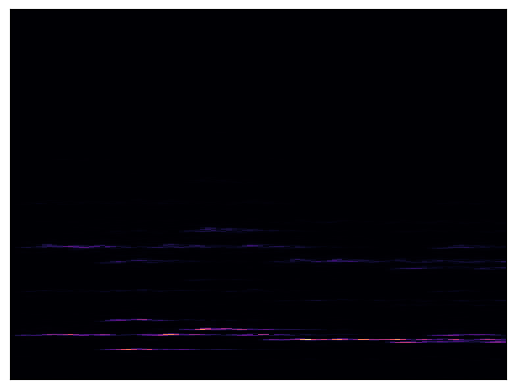

In [103]:
librosa.display.specshow(np.abs(dataset[0]), sr=16_000, hop_length=2047//4)
np.abs(dataset[0]).shape